# Twitter Sentiment Analysis

In [1]:
# !pip install gensim --upgrade
# !pip install keras --upgrade
# !pip install pandas --upgrade

In [2]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


In [3]:
import keras
print(keras.__version__)
import tensorflow as tf
print(tf.__version__)

2.2.4
1.11.0-rc1


In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Settings

In [6]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [7]:
dataset_filename = os.listdir("../input")[0]
dataset_path = os.path.join("..","input",dataset_filename)
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: ../input/training.1600000.processed.noemoticon.csv


In [8]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [9]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [10]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [11]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 1.04 s, sys: 39.7 ms, total: 1.08 s
Wall time: 1.08 s


Text(0.5,1,'Dataset labels distribuition')

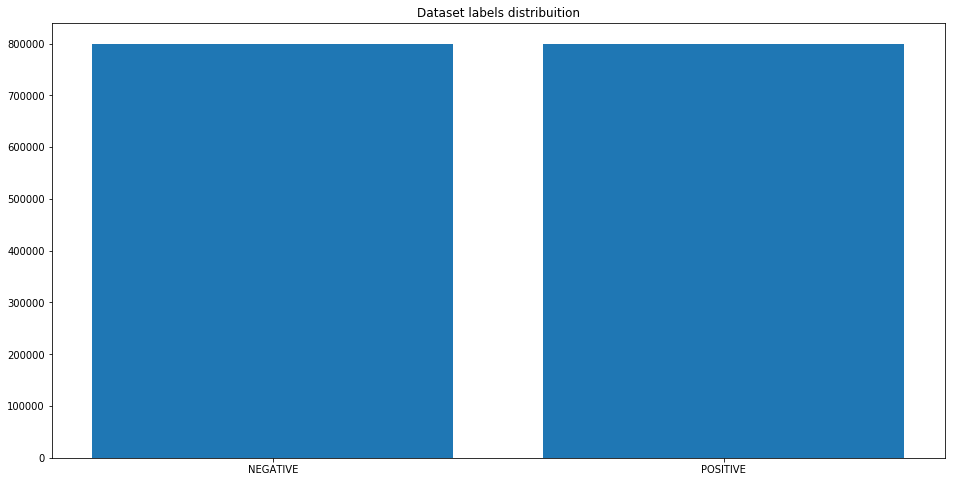

In [12]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [13]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [14]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [15]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 1min 6s, sys: 184 ms, total: 1min 6s
Wall time: 1min 7s


In [17]:
print('Changed text & labels...')
df.head(5)

Changed text & labels...


,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset update facebook texting might cry result...
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times ball managed save 50 rest go ...
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behaving mad see


### Split train and test

In [18]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


### Word2Vec 

In [19]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 3.27 s, sys: 304 ms, total: 3.58 s
Wall time: 3.59 s


In [20]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [21]:
w2v_model.build_vocab(documents)

2020-05-31 08:34:45,985 : INFO : collecting all words and their counts
2020-05-31 08:34:45,988 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-05-31 08:34:46,016 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2020-05-31 08:34:46,041 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2020-05-31 08:34:46,067 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2020-05-31 08:34:46,093 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2020-05-31 08:34:46,118 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2020-05-31 08:34:46,146 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2020-05-31 08:34:46,174 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2020-05-31 08:34:46,201 : INFO : PROGRESS: at s

2020-05-31 08:34:47,953 : INFO : PROGRESS: at sentence #720000, processed 5193881 words, keeping 200325 word types
2020-05-31 08:34:47,980 : INFO : PROGRESS: at sentence #730000, processed 5265467 words, keeping 202133 word types
2020-05-31 08:34:48,007 : INFO : PROGRESS: at sentence #740000, processed 5337518 words, keeping 203818 word types
2020-05-31 08:34:48,035 : INFO : PROGRESS: at sentence #750000, processed 5409321 words, keeping 205535 word types
2020-05-31 08:34:48,062 : INFO : PROGRESS: at sentence #760000, processed 5481512 words, keeping 207282 word types
2020-05-31 08:34:48,089 : INFO : PROGRESS: at sentence #770000, processed 5554093 words, keeping 209076 word types
2020-05-31 08:34:48,116 : INFO : PROGRESS: at sentence #780000, processed 5625382 words, keeping 210805 word types
2020-05-31 08:34:48,143 : INFO : PROGRESS: at sentence #790000, processed 5698066 words, keeping 212618 word types
2020-05-31 08:34:48,171 : INFO : PROGRESS: at sentence #800000, processed 577088

In [22]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [23]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-05-31 08:36:04,932 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-05-31 08:36:05,979 : INFO : EPOCH 1 - PROGRESS: at 4.23% examples, 335084 words/s, in_qsize 16, out_qsize 0
2020-05-31 08:36:07,018 : INFO : EPOCH 1 - PROGRESS: at 9.34% examples, 369069 words/s, in_qsize 16, out_qsize 0
2020-05-31 08:36:08,054 : INFO : EPOCH 1 - PROGRESS: at 14.65% examples, 386400 words/s, in_qsize 15, out_qsize 0
2020-05-31 08:36:09,060 : INFO : EPOCH 1 - PROGRESS: at 19.94% examples, 397948 words/s, in_qsize 15, out_qsize 0
2020-05-31 08:36:10,103 : INFO : EPOCH 1 - PROGRESS: at 24.72% examples, 393582 words/s, in_qsize 15, out_qsize 0
2020-05-31 08:36:11,136 : INFO : EPOCH 1 - PROGRESS: at 29.26% examples, 388392 words/s, in_qsize 16, out_qsize 0
2020-05-31 08:36:12,301 : INFO : EPOCH 1 - PROGRESS: at 33.70% examples, 376483 words/s, in_qsize 11, out_qsize 1
2020-05-31 08:36:13,337 : INFO : EPOCH 1 - PROGRESS: a

2020-05-31 08:37:04,825 : INFO : EPOCH 3 - PROGRESS: at 81.01% examples, 378918 words/s, in_qsize 12, out_qsize 1
2020-05-31 08:37:05,832 : INFO : EPOCH 3 - PROGRESS: at 85.23% examples, 377074 words/s, in_qsize 14, out_qsize 1
2020-05-31 08:37:06,867 : INFO : EPOCH 3 - PROGRESS: at 90.00% examples, 377218 words/s, in_qsize 15, out_qsize 0
2020-05-31 08:37:07,927 : INFO : EPOCH 3 - PROGRESS: at 93.48% examples, 371591 words/s, in_qsize 14, out_qsize 1
2020-05-31 08:37:09,010 : INFO : EPOCH 3 - PROGRESS: at 99.23% examples, 374781 words/s, in_qsize 8, out_qsize 0
2020-05-31 08:37:09,017 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-05-31 08:37:09,022 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-05-31 08:37:09,024 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-05-31 08:37:09,025 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-05-31 08:37:09,026 : INFO : worker thread finished; awaiting f

2020-05-31 08:37:57,202 : INFO : EPOCH 6 - PROGRESS: at 25.15% examples, 336798 words/s, in_qsize 13, out_qsize 2
2020-05-31 08:37:58,218 : INFO : EPOCH 6 - PROGRESS: at 29.91% examples, 343759 words/s, in_qsize 15, out_qsize 0
2020-05-31 08:37:59,220 : INFO : EPOCH 6 - PROGRESS: at 34.78% examples, 350683 words/s, in_qsize 14, out_qsize 1
2020-05-31 08:38:00,250 : INFO : EPOCH 6 - PROGRESS: at 39.43% examples, 353076 words/s, in_qsize 14, out_qsize 6
2020-05-31 08:38:01,260 : INFO : EPOCH 6 - PROGRESS: at 44.07% examples, 355636 words/s, in_qsize 14, out_qsize 2
2020-05-31 08:38:02,316 : INFO : EPOCH 6 - PROGRESS: at 48.19% examples, 352353 words/s, in_qsize 15, out_qsize 3
2020-05-31 08:38:03,340 : INFO : EPOCH 6 - PROGRESS: at 52.40% examples, 351276 words/s, in_qsize 16, out_qsize 0
2020-05-31 08:38:04,345 : INFO : EPOCH 6 - PROGRESS: at 57.60% examples, 356891 words/s, in_qsize 15, out_qsize 0
2020-05-31 08:38:05,400 : INFO : EPOCH 6 - PROGRESS: at 62.68% examples, 359826 words/s,

2020-05-31 08:38:53,730 : INFO : EPOCH 8 - PROGRESS: at 99.67% examples, 397661 words/s, in_qsize 3, out_qsize 1
2020-05-31 08:38:53,732 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-05-31 08:38:53,739 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-05-31 08:38:53,746 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-05-31 08:38:53,749 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-05-31 08:38:53,750 : INFO : EPOCH - 8 : training on 9227204 raw words (8222404 effective words) took 20.6s, 398576 effective words/s
2020-05-31 08:38:54,895 : INFO : EPOCH 9 - PROGRESS: at 5.10% examples, 373287 words/s, in_qsize 15, out_qsize 2
2020-05-31 08:38:56,016 : INFO : EPOCH 9 - PROGRESS: at 10.21% examples, 371113 words/s, in_qsize 15, out_qsize 0
2020-05-31 08:38:57,019 : INFO : EPOCH 9 - PROGRESS: at 13.79% examples, 346965 words/s, in_qsize 13, out_qsize 0
2020-05-31 08:38:58,047 : INFO : EPOCH 9 - P

2020-05-31 08:39:50,311 : INFO : EPOCH 11 - PROGRESS: at 72.97% examples, 413130 words/s, in_qsize 15, out_qsize 0
2020-05-31 08:39:51,313 : INFO : EPOCH 11 - PROGRESS: at 76.55% examples, 405409 words/s, in_qsize 14, out_qsize 0
2020-05-31 08:39:52,454 : INFO : EPOCH 11 - PROGRESS: at 80.68% examples, 397966 words/s, in_qsize 15, out_qsize 0
2020-05-31 08:39:53,455 : INFO : EPOCH 11 - PROGRESS: at 84.04% examples, 391083 words/s, in_qsize 15, out_qsize 0
2020-05-31 08:39:54,502 : INFO : EPOCH 11 - PROGRESS: at 89.13% examples, 391556 words/s, in_qsize 13, out_qsize 2
2020-05-31 08:39:55,525 : INFO : EPOCH 11 - PROGRESS: at 94.91% examples, 395163 words/s, in_qsize 15, out_qsize 0
2020-05-31 08:39:56,374 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-05-31 08:39:56,383 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-05-31 08:39:56,385 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-05-31 08:39:56,389 : INFO : work

2020-05-31 08:40:43,114 : INFO : EPOCH 14 - PROGRESS: at 30.24% examples, 398058 words/s, in_qsize 15, out_qsize 0
2020-05-31 08:40:44,247 : INFO : EPOCH 14 - PROGRESS: at 36.18% examples, 403318 words/s, in_qsize 15, out_qsize 1
2020-05-31 08:40:45,248 : INFO : EPOCH 14 - PROGRESS: at 41.80% examples, 410420 words/s, in_qsize 15, out_qsize 4
2020-05-31 08:40:46,281 : INFO : EPOCH 14 - PROGRESS: at 46.99% examples, 410855 words/s, in_qsize 16, out_qsize 0
2020-05-31 08:40:47,289 : INFO : EPOCH 14 - PROGRESS: at 51.64% examples, 407907 words/s, in_qsize 15, out_qsize 0
2020-05-31 08:40:48,306 : INFO : EPOCH 14 - PROGRESS: at 55.21% examples, 397325 words/s, in_qsize 15, out_qsize 0
2020-05-31 08:40:49,395 : INFO : EPOCH 14 - PROGRESS: at 60.96% examples, 400477 words/s, in_qsize 15, out_qsize 0
2020-05-31 08:40:50,435 : INFO : EPOCH 14 - PROGRESS: at 65.38% examples, 396675 words/s, in_qsize 15, out_qsize 0
2020-05-31 08:40:51,517 : INFO : EPOCH 14 - PROGRESS: at 69.94% examples, 392923

2020-05-31 08:41:37,704 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-05-31 08:41:37,707 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-05-31 08:41:37,708 : INFO : EPOCH - 16 : training on 9227204 raw words (8223472 effective words) took 19.9s, 414037 effective words/s
2020-05-31 08:41:38,729 : INFO : EPOCH 17 - PROGRESS: at 4.56% examples, 369889 words/s, in_qsize 12, out_qsize 2
2020-05-31 08:41:39,740 : INFO : EPOCH 17 - PROGRESS: at 10.21% examples, 414120 words/s, in_qsize 15, out_qsize 1
2020-05-31 08:41:40,750 : INFO : EPOCH 17 - PROGRESS: at 14.86% examples, 402402 words/s, in_qsize 15, out_qsize 0
2020-05-31 08:41:41,761 : INFO : EPOCH 17 - PROGRESS: at 19.19% examples, 389814 words/s, in_qsize 15, out_qsize 0
2020-05-31 08:41:42,790 : INFO : EPOCH 17 - PROGRESS: at 22.98% examples, 372285 words/s, in_qsize 15, out_qsize 0
2020-05-31 08:41:43,792 : INFO : EPOCH 17 - PROGRESS: at 27.86% examples, 376845 words/s, in_qsize 13, ou

2020-05-31 08:42:35,597 : INFO : EPOCH 19 - PROGRESS: at 83.61% examples, 416531 words/s, in_qsize 12, out_qsize 3
2020-05-31 08:42:36,650 : INFO : EPOCH 19 - PROGRESS: at 88.16% examples, 412818 words/s, in_qsize 13, out_qsize 2
2020-05-31 08:42:37,683 : INFO : EPOCH 19 - PROGRESS: at 92.06% examples, 407124 words/s, in_qsize 16, out_qsize 0
2020-05-31 08:42:38,688 : INFO : EPOCH 19 - PROGRESS: at 97.61% examples, 409429 words/s, in_qsize 14, out_qsize 2
2020-05-31 08:42:38,931 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-05-31 08:42:38,971 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-05-31 08:42:38,973 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-05-31 08:42:38,976 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-05-31 08:42:39,016 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-05-31 08:42:39,018 : INFO : worker thread finished; awaiting finish of 2 more th

2020-05-31 08:43:27,931 : INFO : EPOCH 22 - PROGRESS: at 41.05% examples, 400021 words/s, in_qsize 16, out_qsize 0
2020-05-31 08:43:28,951 : INFO : EPOCH 22 - PROGRESS: at 46.57% examples, 404942 words/s, in_qsize 16, out_qsize 0
2020-05-31 08:43:30,035 : INFO : EPOCH 22 - PROGRESS: at 51.64% examples, 404523 words/s, in_qsize 14, out_qsize 6
2020-05-31 08:43:31,004 : INFO : EPOCH 22 - PROGRESS: at 56.84% examples, 406302 words/s, in_qsize 14, out_qsize 3
2020-05-31 08:43:32,011 : INFO : EPOCH 22 - PROGRESS: at 61.39% examples, 403499 words/s, in_qsize 16, out_qsize 0
2020-05-31 08:43:33,032 : INFO : EPOCH 22 - PROGRESS: at 64.84% examples, 394115 words/s, in_qsize 15, out_qsize 0
2020-05-31 08:43:34,038 : INFO : EPOCH 22 - PROGRESS: at 70.59% examples, 399329 words/s, in_qsize 15, out_qsize 0
2020-05-31 08:43:35,096 : INFO : EPOCH 22 - PROGRESS: at 75.89% examples, 400185 words/s, in_qsize 15, out_qsize 0
2020-05-31 08:43:36,173 : INFO : EPOCH 22 - PROGRESS: at 81.66% examples, 402645

2020-05-31 08:44:20,253 : INFO : EPOCH - 24 : training on 9227204 raw words (8223038 effective words) took 20.0s, 411621 effective words/s
2020-05-31 08:44:21,393 : INFO : EPOCH 25 - PROGRESS: at 5.00% examples, 362427 words/s, in_qsize 14, out_qsize 4
2020-05-31 08:44:22,518 : INFO : EPOCH 25 - PROGRESS: at 10.97% examples, 399184 words/s, in_qsize 15, out_qsize 0
2020-05-31 08:44:23,538 : INFO : EPOCH 25 - PROGRESS: at 16.16% examples, 407523 words/s, in_qsize 16, out_qsize 4
2020-05-31 08:44:24,529 : INFO : EPOCH 25 - PROGRESS: at 21.90% examples, 421788 words/s, in_qsize 14, out_qsize 0
2020-05-31 08:44:25,556 : INFO : EPOCH 25 - PROGRESS: at 27.10% examples, 420746 words/s, in_qsize 13, out_qsize 2
2020-05-31 08:44:26,583 : INFO : EPOCH 25 - PROGRESS: at 31.32% examples, 407289 words/s, in_qsize 15, out_qsize 0
2020-05-31 08:44:27,606 : INFO : EPOCH 25 - PROGRESS: at 35.75% examples, 400299 words/s, in_qsize 15, out_qsize 0
2020-05-31 08:44:28,682 : INFO : EPOCH 25 - PROGRESS: at 

2020-05-31 08:45:19,448 : INFO : EPOCH 27 - PROGRESS: at 94.25% examples, 418887 words/s, in_qsize 16, out_qsize 0
2020-05-31 08:45:20,371 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-05-31 08:45:20,388 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-05-31 08:45:20,406 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-05-31 08:45:20,427 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-05-31 08:45:20,431 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-05-31 08:45:20,432 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-05-31 08:45:20,437 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-05-31 08:45:20,439 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-05-31 08:45:20,440 : INFO : EPOCH - 27 : training on 9227204 raw words (8222974 effective words) took 19.5s, 421834 effective words/s
2020-05-31 08:45:2

2020-05-31 08:46:11,460 : INFO : EPOCH 30 - PROGRESS: at 50.13% examples, 405957 words/s, in_qsize 16, out_qsize 0
2020-05-31 08:46:12,465 : INFO : EPOCH 30 - PROGRESS: at 55.21% examples, 406933 words/s, in_qsize 11, out_qsize 4
2020-05-31 08:46:13,472 : INFO : EPOCH 30 - PROGRESS: at 60.74% examples, 410630 words/s, in_qsize 15, out_qsize 0
2020-05-31 08:46:14,499 : INFO : EPOCH 30 - PROGRESS: at 65.93% examples, 411626 words/s, in_qsize 15, out_qsize 0
2020-05-31 08:46:15,486 : INFO : EPOCH 30 - PROGRESS: at 71.45% examples, 414477 words/s, in_qsize 16, out_qsize 0
2020-05-31 08:46:16,585 : INFO : EPOCH 30 - PROGRESS: at 76.11% examples, 409726 words/s, in_qsize 15, out_qsize 0
2020-05-31 08:46:17,722 : INFO : EPOCH 30 - PROGRESS: at 80.46% examples, 403052 words/s, in_qsize 14, out_qsize 1
2020-05-31 08:46:18,742 : INFO : EPOCH 30 - PROGRESS: at 85.45% examples, 402992 words/s, in_qsize 16, out_qsize 0
2020-05-31 08:46:19,775 : INFO : EPOCH 30 - PROGRESS: at 90.65% examples, 403586

CPU times: user 19min 20s, sys: 6.17 s, total: 19min 26s
Wall time: 10min 56s


(263126202, 295270528)

In [24]:
w2v_model.most_similar("love")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-05-31 08:47:28,671 : INFO : precomputing L2-norms of word weight vectors
/opt/conda/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('luv', 0.5696961879730225),
 ('loves', 0.5488146543502808),
 ('loved', 0.52984219789505),
 ('adore', 0.507583498954773),
 ('amazing', 0.5023819804191589),
 ('looove', 0.48286324739456177),
 ('loooove', 0.4642808735370636),
 ('lovee', 0.4641185998916626),
 ('loveee', 0.4631948471069336),
 ('awesome', 0.45769333839416504)]

### Tokenize Text

In [25]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 27.4 s, sys: 110 ms, total: 27.5 s
Wall time: 27.9 s


In [26]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 44.4 s, sys: 964 ms, total: 45.4 s
Wall time: 45.7 s


### Label Encoder 

In [27]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [28]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [29]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [30]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

### Embedding layer

In [31]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [32]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [33]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          87125700  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


### Compile model

In [34]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [35]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/8
1152000/1152000 [==============================] - 614s 533us/step - loss: 0.5039 - acc: 0.7506 - val_loss: 0.4668 - val_acc: 0.7786
Epoch 2/8
1152000/1152000 [==============================] - 611s 530us/step - loss: 0.4796 - acc: 0.7672 - val_loss: 0.4586 - val_acc: 0.7836
Epoch 3/8
1057792/1152000 [==========================>...] - ETA: 47s - loss: 0.4728 - acc: 0.7713

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

### Evaluate

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
predict("I love the music")

In [ ]:
predict("I hate the rain")

In [ ]:
predict("i don't know what i'm doing")

In [ ]:
predict("Asco 2020 sees multiple myeloma responses deepen")

### Confusion Matrix

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

### Accuracy Score

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

### Save model

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)